In [52]:
import os
import pandas as pd

os.chdir("/scratch/project/tcr_ml/gnn_release/clonal_frequency_scoring")

samples = {
    "cancer": "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/phs002517/2c1256e6-3f87-4943-8463-b8983ab78e5d_merged.csv",
    "control": "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/PICA/20240918_WGS_20240924_sc_PICA0008-PICA0032_Pool_7_1_merged.csv",
}

dfs = []
for samp in samples:
    df = pd.read_csv(samples[samp])
    df["sample"] = samp
    dfs.append(df)

import matplotlib.pyplot as plt

plt.figure(figsize=(2, 4))

<Figure size 200x400 with 0 Axes>

<Figure size 200x400 with 0 Axes>

In [53]:
df = pd.concat(dfs)

In [54]:
df

,AA_seq,CloneFreq,prob,high,transformed_score,sample
0,CSVERGYNEQFF,0.121951,0.999494,True,0.121889,cancer
1,CASSSGTSGGHTDTQYF,0.097561,1.000000,True,0.097561,cancer
2,CATSGQGAYEQYF,0.097561,0.000680,False,0.000066,cancer
3,CASSSDRNGYTF,0.073171,0.136786,False,0.010009,cancer
4,CAWSPGGGLQEQFF,0.048780,0.342822,False,0.016723,cancer
...,...,...,...,...,...,...
7469,CASSLSSYEQYF,0.000028,0.996774,True,0.000028,control
7470,CASKAGSRGTEAFF,0.000028,0.349361,False,0.000010,control
7471,CASASPRRLAYEQYF,0.000028,0.301745,False,0.000008,control
7472,CASTTAGMGTEAFF,0.000028,0.349833,False,0.000010,control


<Axes: xlabel='sample', ylabel='prob'>

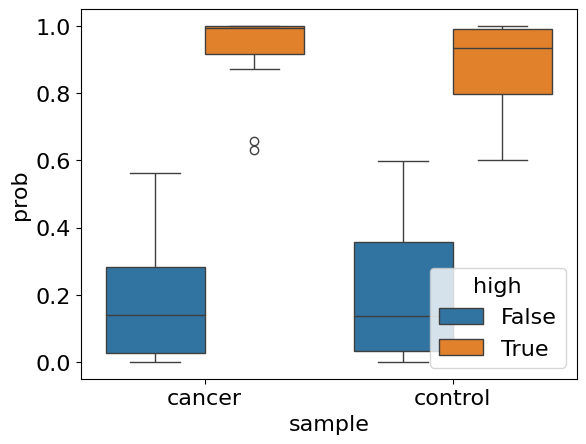

In [55]:
import seaborn as sns

sns.boxplot(x="sample", y="prob", hue="high", data=df)

/scratch/project_mnt/S0163/gnn_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


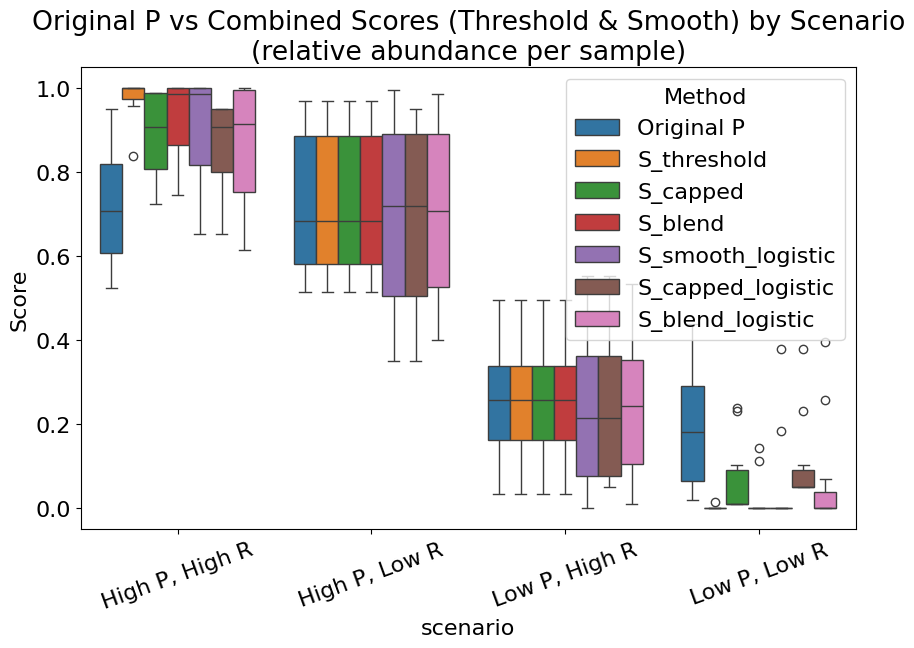

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata

# from caas_jupyter_tools import display_dataframe_to_user

# --- Functions ---


import numpy as np
from scipy.stats import rankdata


def fraction_to_percentile(F_raw, eps=1e-9):
    """
    Convert raw feature values into percentile ranks in [0,1].

    Each value in F_raw is compared to all other values in the same sample
    to determine its percentile position. The lowest value will map close
    to 0, the highest to 1, and intermediate values are linearly scaled
    in between. This allows you to work with relative abundances or rankings
    instead of raw magnitudes, which might vary across samples.

    Parameters
    ----------
    F_raw : array-like
        Raw feature values (e.g., counts, abundances, intensities).
    eps : float, optional
        Small constant to avoid division by zero. Default = 1e-9.

    Returns
    -------
    R : np.ndarray
        Percentile-transformed values of F_raw in the interval [0,1].
    """
    n = len(F_raw)

    # If the sample has only one element, percentile ranking is meaningless.
    # Return a neutral percentile of 0.5 so it sits in the middle.
    if n <= 1:
        return np.array([0.5])

    # Rank the values in ascending order. The smallest gets rank=1, largest rank=n.
    # Subtract 1.0 so the smallest element has rank 0 instead of 1.
    # If there are ties, they get the average rank.
    ranks = rankdata(F_raw, method="average") - 1.0

    # Scale the ranks into [0,1] by dividing by the maximum possible rank (n-1).
    # This ensures the lowest rank is 0.0 and the highest rank is 1.0.
    return ranks / max(1.0, n - 1.0)


def combined_score_sample(P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8):
    """
    Agreement-based score adjustment using thresholds.

    This function adjusts P based on whether P and the percentile-transformed
    F_raw (denoted R) are simultaneously high or low.

    - If both P and R exceed their thresholds → apply a positive adjustment.
    - If both P and R are below their thresholds → apply a negative adjustment.
    - Otherwise (mixed signals), no adjustment is applied.

    The magnitude of the adjustment is proportional to the "weakest"
    signal (the smaller of P and R for positive cases, or the smaller
    of (1-P) and (1-R) for negative cases).

    Parameters
    ----------
    P : array-like
        Input probabilities/scores in [0,1].
    F_raw : array-like
        Raw feature values, converted into percentiles internally.
    t_P : float
        Threshold for P above which it is considered "high".
    t_R : float
        Threshold for R above which it is considered "high".
    alpha : float
        Weight controlling the strength of positive adjustments.
    beta : float
        Weight controlling the strength of negative adjustments.

    Returns
    -------
    S : np.ndarray
        Adjusted scores, clipped into [0,1].
    R : np.ndarray
        Percentile ranks of F_raw.
    """
    # Ensure P is within valid probability range
    P = np.clip(P, 0.0, 1.0)

    # Convert raw features into percentiles
    R = fraction_to_percentile(F_raw)

    # Identify elements where both P and R are above thresholds
    mask_high = (P > t_P) & (R > t_R)

    # Initialize array of positive contributions (all zeros)
    A_high = np.zeros_like(P)

    # For "high" elements, assign the positive adjustment strength.
    # Use min(P, R) so adjustment is limited by the weaker of the two.
    A_high[mask_high] = np.minimum(P[mask_high], R[mask_high])

    # Identify elements where both P and R are below thresholds
    mask_low = (P < t_P) & (R < t_R)

    # Initialize array of negative contributions
    A_low = np.zeros_like(P)

    # For "low" elements, assign the negative adjustment strength.
    # Use min(1-P, 1-R) to measure how far both are from the "high" region.
    A_low[mask_low] = np.minimum(1 - P[mask_low], 1 - R[mask_low])

    # Compute adjusted score:
    # Start from P, then add positive contributions (scaled by alpha)
    # and subtract negative contributions (scaled by beta).
    S = P + alpha * A_high - beta * A_low

    # Clip final score into valid probability range
    return np.clip(S, 0.0, 1.0), R


def combined_score_sample_capped(
    P,
    F_raw,
    t_P=0.5,
    t_R=0.5,
    alpha=0.6,
    beta=0.8,
    delta_max=0.2,
    floor=0.01,
    ceil=0.99,
):
    """
    Threshold-based score adjustment with a cap on adjustment size.

    Similar to combined_score_sample, but the net adjustment (delta) is
    clipped to prevent excessively large changes. Additionally, the final
    score is clipped into a restricted range [floor, ceil].

    Parameters
    ----------
    P : array-like
        Input probabilities/scores in [0,1].
    F_raw : array-like
        Raw feature values, converted into percentiles internally.
    t_P : float
        Threshold for P above which it is considered "high".
    t_R : float
        Threshold for R above which it is considered "high".
    alpha : float
        Weight controlling the strength of positive adjustments.
    beta : float
        Weight controlling the strength of negative adjustments.
    delta_max : float
        Maximum allowed absolute adjustment (cap).
    floor : float
        Minimum possible final score.
    ceil : float
        Maximum possible final score.

    Returns
    -------
    S : np.ndarray
        Adjusted scores, clipped into [floor, ceil].
    R : np.ndarray
        Percentile ranks of F_raw.
    """
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    # Identify high cases (both P and R exceed thresholds)
    mask_high = (P > t_P) & (R > t_R)
    A_high = np.zeros_like(P)
    A_high[mask_high] = np.minimum(P[mask_high], R[mask_high])

    # Identify low cases (both P and R below thresholds)
    mask_low = (P < t_P) & (R < t_R)
    A_low = np.zeros_like(P)
    A_low[mask_low] = np.minimum(1 - P[mask_low], 1 - R[mask_low])

    # Compute the raw adjustment amount
    delta = alpha * A_high - beta * A_low

    # Cap delta to be within [-delta_max, delta_max]
    delta = np.clip(delta, -delta_max, delta_max)

    # Apply capped adjustment to original P
    S = P + delta

    # Clip final score to floor/ceil bounds
    return np.clip(S, floor, ceil), R


def combined_score_sample_blend(
    P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8, gamma=0.7
):
    """
    Threshold-based adjustment blended with the original score.

    This method first computes an adjusted score like combined_score_sample,
    then blends it with the original P using a weighted average.

    - gamma = 0 → final score is 100% original P (no adjustment).
    - gamma = 1 → final score is 100% adjusted score (full adjustment).
    - 0 < gamma < 1 → final score is somewhere between P and adjusted score.

    This blending helps moderate adjustments, making the function less
    sensitive to small changes near thresholds.

    Parameters
    ----------
    P : array-like
        Input probabilities/scores in [0,1].
    F_raw : array-like
        Raw feature values, converted into percentiles internally.
    t_P : float
        Threshold for P.
    t_R : float
        Threshold for R (percentile).
    alpha : float
        Weight for positive adjustment.
    beta : float
        Weight for negative adjustment.
    gamma : float
        Blending factor in [0,1].

    Returns
    -------
    S : np.ndarray
        Blended adjusted scores, clipped to [0,1].
    R : np.ndarray
        Percentile ranks of F_raw.
    """
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    mask_high = (P > t_P) & (R > t_R)
    A_high = np.zeros_like(P)
    A_high[mask_high] = np.minimum(P[mask_high], R[mask_high])

    mask_low = (P < t_P) & (R < t_R)
    A_low = np.zeros_like(P)
    A_low[mask_low] = np.minimum(1 - P[mask_low], 1 - R[mask_low])

    # Compute adjusted score using thresholds
    S_adjusted = P + alpha * A_high - beta * A_low

    # Blend adjusted score with original P.
    # Equivalent to: S = P + gamma * (S_adjusted - P)
    S = (1 - gamma) * P + gamma * S_adjusted

    return np.clip(S, 0.0, 1.0), R


def combined_score_sample_smooth(
    P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8, k=8.0
):
    """
    Smooth variant using logistic weights instead of hard thresholds.

    Instead of treating values strictly as "above threshold" or "below threshold",
    this version applies a logistic weighting function that smoothly transitions
    around thresholds. This avoids abrupt jumps in adjustments.

    Parameters
    ----------
    P : array-like
        Input probabilities/scores in [0,1].
    F_raw : array-like
        Raw feature values, converted into percentiles internally.
    t_P : float
        Threshold for P.
    t_R : float
        Threshold for R (percentile).
    alpha : float
        Weight for positive adjustment.
    beta : float
        Weight for negative adjustment.
    k : float
        Steepness of the logistic function.
        - Larger k → sharper transition (more like a hard threshold).
        - Smaller k → smoother transition.

    Returns
    -------
    S : np.ndarray
        Smoothly adjusted scores, clipped to [0,1].
    R : np.ndarray
        Percentile ranks of F_raw.
    """
    P = np.clip(P, 0.0, 1.0)
    R = fraction_to_percentile(F_raw)

    # Logistic sigmoid function maps real numbers smoothly into (0,1).
    # Used here to assign soft weights around thresholds.
    def sig(x):
        return 1.0 / (1.0 + np.exp(-x))

    # Compute smooth "weights" for P and R relative to thresholds.
    # These are near 0 if far below threshold, near 1 if far above threshold,
    # and around 0.5 when close to threshold.
    wP = sig(k * (P - t_P))
    wR = sig(k * (R - t_R))

    # Positive adjustment contribution:
    # High when both P and R are above thresholds, scaled smoothly.
    A_high = P * R * wP * wR

    # Negative adjustment contribution:
    # High when both P and R are below thresholds, also scaled smoothly.
    A_low = (1 - P) * (1 - R) * (1 - wP) * (1 - wR)

    # Apply weighted positive and negative adjustments to P
    S = P + alpha * A_high - beta * A_low

    return np.clip(S, 0.0, 1.0), R


def combined_score_sample_capped_logistic(
    P,
    F_raw,
    t_P=0.5,
    t_R=0.5,
    alpha=0.6,
    beta=0.8,
    k=8.0,
    delta_max=0.2,
    floor=0.05,
    ceil=0.95,
):
    """
    Compute a capped combined score using logistic-weighted adjustments.

    Each element in P is adjusted based on its own value and the corresponding
    percentile R of the raw feature F_raw. High P & R increase the score,
    low P & R decrease it. The adjustment is smoothed with logistic weights
    instead of hard thresholds, then capped to avoid extreme changes.

    Parameters
    ----------
    P : array-like
        Original scores/probabilities in [0, 1].
    F_raw : array-like
        Raw feature values to be converted into percentiles.
    t_P : float
        Threshold for P to start contributing positively.
    t_R : float
        Threshold for R to start contributing positively.
    alpha : float
        Weight for positive adjustment (when P and R are high).
    beta : float
        Weight for negative adjustment (when P and R are low).
    k : float
        Logistic steepness controlling smoothness near thresholds.
    delta_max : float
        Maximum allowed adjustment magnitude.
    floor : float
        Minimum allowed final score.
    ceil : float
        Maximum allowed final score.

    Returns
    -------
    S : np.ndarray
        Adjusted scores, clipped to [floor, ceil].
    R : np.ndarray
        Percentile-transformed values of F_raw.
    """
    # Convert raw features to percentile scores (0 to 1)
    R = fraction_to_percentile(F_raw)

    # Logistic sigmoid function
    def sig(x):
        return 1.0 / (1.0 + np.exp(-x))

    # Compute smooth weights for P and R based on thresholds
    wP = sig(k * (P - t_P))  # closer to 1 if P > t_P
    wR = sig(k * (R - t_R))  # closer to 1 if R > t_R

    # Positive contribution: both P and R are high
    A_high = P * R * wP * wR

    # Negative contribution: both P and R are low
    A_low = (1 - P) * (1 - R) * (1 - wP) * (1 - wR)

    # Combine positive and negative contributions with weights
    delta = alpha * A_high - beta * A_low

    # Cap the adjustment to avoid extreme changes
    delta = np.clip(delta, -delta_max, delta_max)

    # Compute final score
    S = P + delta

    # Clip final score to specified bounds
    return np.clip(S, floor, ceil), R


def combined_score_sample_blend_logistic(
    P, F_raw, t_P=0.5, t_R=0.5, alpha=0.6, beta=0.8, gamma=0.7, k=8.0
):
    """
    Compute a blended combined score using logistic-weighted adjustments.

    Each element in P is adjusted based on its own value and the corresponding
    percentile R of the raw feature F_raw. High P & R increase the score,
    low P & R decrease it. The adjustment is smoothed with logistic weights
    and then blended with the original P to moderate the effect.

    Parameters
    ----------
    P : array-like
        Original scores/probabilities in [0, 1].
    F_raw : array-like
        Raw feature values to be converted into percentiles.
    t_P : float
        Threshold for P to start contributing positively.
    t_R : float
        Threshold for R to start contributing positively.
    alpha : float
        Weight for positive adjustment (when P and R are high).
    beta : float
        Weight for negative adjustment (when P and R are low).
    gamma : float
        Blending factor (0 = original P, 1 = fully adjusted score).
    k : float
        Logistic steepness controlling smoothness near thresholds.

    Returns
    -------
    S : np.ndarray
        Adjusted and blended scores, clipped to [0, 1].
    R : np.ndarray
        Percentile-transformed values of F_raw.
    """
    # Convert raw features to percentile scores (0 to 1)
    R = fraction_to_percentile(F_raw)

    # Logistic sigmoid function
    def sig(x):
        return 1.0 / (1.0 + np.exp(-x))

    # Compute smooth weights for P and R based on thresholds
    wP = sig(k * (P - t_P))
    wR = sig(k * (R - t_R))

    # Positive adjustment: high P & high R
    A_high = P * R * wP * wR

    # Negative adjustment: low P & low R
    A_low = (1 - P) * (1 - R) * (1 - wP) * (1 - wR)

    # Raw adjusted score
    S_adjusted = P + alpha * A_high - beta * A_low

    # Blend with original P to moderate adjustment
    S = (1 - gamma) * P + gamma * S_adjusted

    # Clip final score to [0,1]
    return np.clip(S, 0.0, 1.0), R


# --- Demo dataset ---

np.random.seed(42)
n_items = 50

# Generate probabilities uniformly [0,1]
P_demo = np.random.rand(n_items)

# Generate cumulative-like abundances (skewed distribution)
F_raw_demo = np.random.exponential(scale=10, size=n_items)

# Run both methods
S_thresh, R_thresh = combined_score_sample(P_demo, F_raw_demo)
S_smooth, R_smooth = combined_score_sample_smooth(P_demo, F_raw_demo)
S_capped, R_capped = combined_score_sample_capped(P_demo, F_raw_demo)
S_blend, R_blend = combined_score_sample_blend(P_demo, F_raw_demo)
S_capped_logistic, R_capped_logistic = combined_score_sample_capped_logistic(
    P_demo, F_raw_demo
)
S_blend_logistic, R_blend_logistic = combined_score_sample_blend_logistic(
    P_demo, F_raw_demo
)

# Create dataframe
df_demo = pd.DataFrame(
    {
        "P": P_demo,
        "F_raw": F_raw_demo,
        "R": R_thresh,
        "S_threshold": S_thresh,
        "S_capped": S_capped,
        "S_blend": S_blend,
        "S_smooth_logistic": S_smooth,
        "S_capped_logistic": S_capped_logistic,
        "S_blend_logistic": S_blend_logistic,
    }
)


# Categorize by scenario relative to thresholds
def categorize(p, r, t=0.5):
    if p > t and r > t:
        return "High P, High R"
    elif p > t and r <= t:
        return "High P, Low R"
    elif p <= t and r > t:
        return "Low P, High R"
    else:
        return "Low P, Low R"


df_demo["scenario"] = [categorize(p, r) for p, r in zip(df_demo["P"], df_demo["R"])]

# Display dataframe to user
# display_dataframe_to_user("Demo sample with relative abundance and combined scores", df_demo)

# --- Boxplots comparing Original P vs Combined ---

df_long = pd.melt(
    df_demo,
    id_vars=["P", "R", "F_raw", "scenario"],
    value_vars=[
        "S_threshold",
        "S_capped",
        "S_blend",
        "S_smooth_logistic",
        "S_capped_logistic",
        "S_blend_logistic",
    ],
    var_name="method",
    value_name="S",
)

# Add original P
df_P = df_demo[["P", "scenario"]].copy()
df_P["method"] = "Original P"
df_P = df_P.rename(columns={"P": "S"})
df_long = pd.concat([df_long, df_P], ignore_index=True)

scenario_order = ["High P, High R", "High P, Low R", "Low P, High R", "Low P, Low R"]
method_order = [
    "Original P",
    "S_threshold",
    "S_capped",
    "S_blend",
    "S_smooth_logistic",
    "S_capped_logistic",
    "S_blend_logistic",
]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="scenario",
    y="S",
    hue="method",
    data=df_long,
    order=scenario_order,
    hue_order=method_order,
)
plt.xticks(rotation=20)
plt.title(
    "Original P vs Combined Scores (Threshold & Smooth) by Scenario\n(relative abundance per sample)"
)
plt.ylabel("Score")
plt.legend(title="Method")
plt.show()

# --- Median shifts per scenario ---
median_shift = df_long.groupby(["scenario", "method"])["S"].median().unstack()
# display_dataframe_to_user("Median shifts per scenario", median_shift.reset_index())

In [57]:
df_demo

,P,F_raw,R,S_threshold,S_capped,S_blend,S_smooth_logistic,S_capped_logistic,S_blend_logistic,scenario
0,0.374540,34.928071,0.979592,0.374540,0.374540,0.374540,0.432181,0.432181,0.414889,"Low P, High R"
1,0.950714,14.922454,0.795918,1.000000,0.990000,1.000000,1.000000,0.950000,1.000000,"High P, High R"
2,0.731994,28.050944,0.959184,1.000000,0.931994,1.000000,1.000000,0.931994,0.980686,"High P, High R"
3,0.598658,22.521520,0.918367,0.957854,0.798658,0.850095,0.817514,0.798658,0.751857,"High P, High R"
4,0.156019,9.110544,0.571429,0.156019,0.156019,0.156019,0.059899,0.059899,0.088735,"Low P, High R"
5,0.155995,25.494354,0.938776,0.155995,0.155995,0.155995,0.159983,0.159983,0.158787,"Low P, High R"
6,0.058084,0.926555,0.122449,0.000000,0.010000,0.000000,0.000000,0.050000,0.000000,"Low P, Low R"
7,0.866176,2.181347,0.224490,0.866176,0.866176,0.866176,0.873391,0.873391,0.871226,"High P, Low R"
8,0.601115,0.462820,0.040816,0.601115,0.601115,0.601115,0.509392,0.509392,0.536909,"High P, Low R"
9,0.708073,3.935321,0.346939,0.708073,0.708073,0.708073,0.717465,0.717465,0.714647,"High P, Low R"


In [58]:
df

,AA_seq,CloneFreq,prob,high,transformed_score,sample
0,CSVERGYNEQFF,0.121951,0.999494,True,0.121889,cancer
1,CASSSGTSGGHTDTQYF,0.097561,1.000000,True,0.097561,cancer
2,CATSGQGAYEQYF,0.097561,0.000680,False,0.000066,cancer
3,CASSSDRNGYTF,0.073171,0.136786,False,0.010009,cancer
4,CAWSPGGGLQEQFF,0.048780,0.342822,False,0.016723,cancer
...,...,...,...,...,...,...
7469,CASSLSSYEQYF,0.000028,0.996774,True,0.000028,control
7470,CASKAGSRGTEAFF,0.000028,0.349361,False,0.000010,control
7471,CASASPRRLAYEQYF,0.000028,0.301745,False,0.000008,control
7472,CASTTAGMGTEAFF,0.000028,0.349833,False,0.000010,control


In [59]:
dfs[0]["S_smooth_logistic"], dfs[0]["R_smooth"] = combined_score_sample_smooth(
    dfs[0]["prob"], dfs[0]["CloneFreq"]
)
dfs[1]["S_smooth_logistic"], dfs[1]["R_smooth"] = combined_score_sample_smooth(
    dfs[1]["prob"], dfs[1]["CloneFreq"]
)

In [60]:
dfs[0]["S_smooth_capped_logistic"], dfs[0]["R_smooth_capped"] = (
    combined_score_sample_capped_logistic(dfs[0]["prob"], dfs[0]["CloneFreq"])
)
dfs[1]["S_smooth_capped_logistic"], dfs[1]["R_smooth_capped"] = (
    combined_score_sample_capped_logistic(dfs[1]["prob"], dfs[1]["CloneFreq"])
)
dfs[0]["S_smooth_blend_logistic"], dfs[0]["R_smooth_blend"] = (
    combined_score_sample_blend_logistic(dfs[0]["prob"], dfs[0]["CloneFreq"])
)
dfs[1]["S_smooth_blend_logistic"], dfs[1]["R_smooth_blend"] = (
    combined_score_sample_blend_logistic(dfs[1]["prob"], dfs[1]["CloneFreq"])
)

dfs[0]["S_smooth_capped"], dfs[0]["R_smooth_capped"] = combined_score_sample_capped(
    dfs[0]["prob"], dfs[0]["CloneFreq"]
)
dfs[1]["S_smooth_capped"], dfs[1]["R_smooth_capped"] = combined_score_sample_capped(
    dfs[1]["prob"], dfs[1]["CloneFreq"]
)
dfs[0]["S_smooth_blend"], dfs[0]["R_smooth_blend"] = combined_score_sample_blend(
    dfs[0]["prob"], dfs[0]["CloneFreq"]
)
dfs[1]["S_smooth_blend"], dfs[1]["R_smooth_blend"] = combined_score_sample_blend(
    dfs[1]["prob"], dfs[1]["CloneFreq"]
)

In [61]:
df = pd.concat(dfs)

<Axes: xlabel='sample', ylabel='prob'>

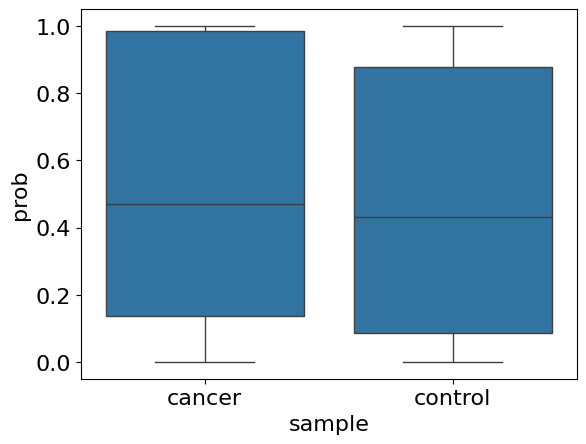

In [62]:
sns.boxplot(x="sample", y="prob", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_logistic'>

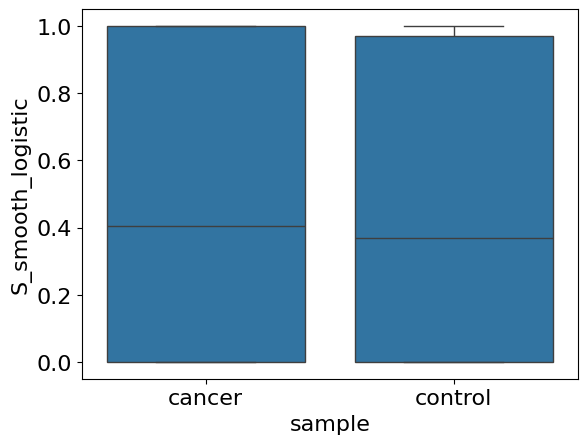

In [63]:
sns.boxplot(x="sample", y="S_smooth_logistic", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_capped_logistic'>

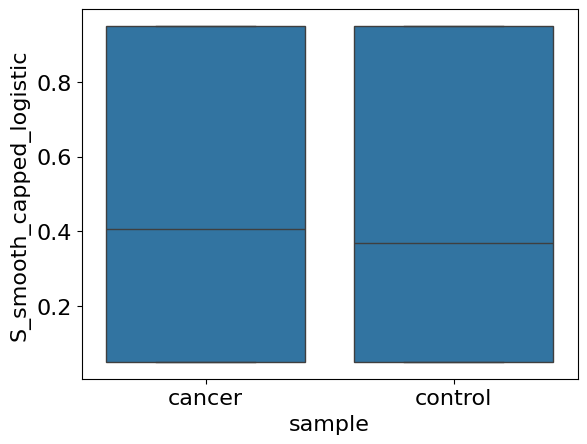

In [64]:
sns.boxplot(x="sample", y="S_smooth_capped_logistic", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_capped'>

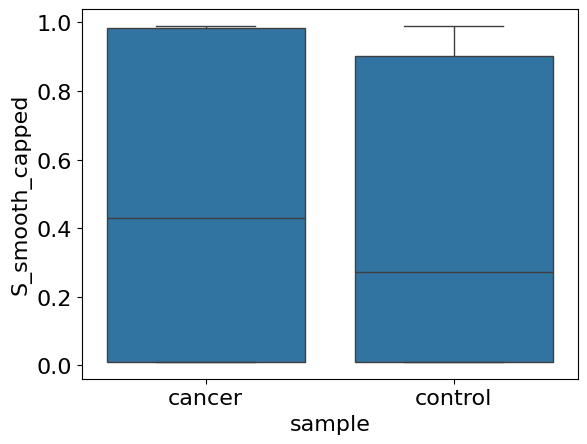

In [65]:
sns.boxplot(x="sample", y="S_smooth_capped", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_blend'>

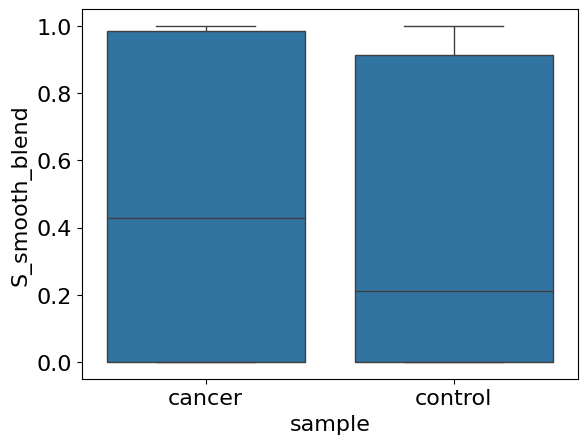

In [66]:
sns.boxplot(x="sample", y="S_smooth_blend", data=df)

<Axes: xlabel='sample', ylabel='S_smooth_blend_logistic'>

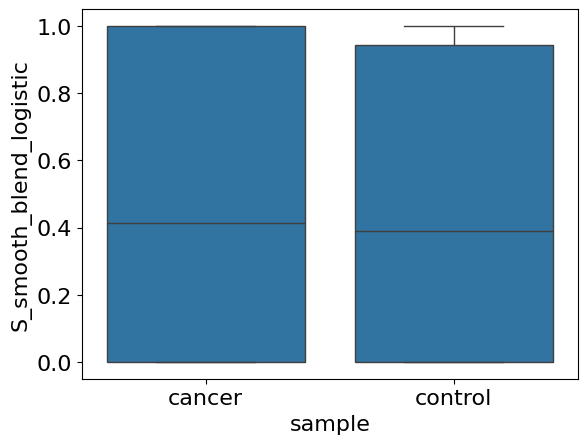

In [67]:
sns.boxplot(x="sample", y="S_smooth_blend_logistic", data=df)

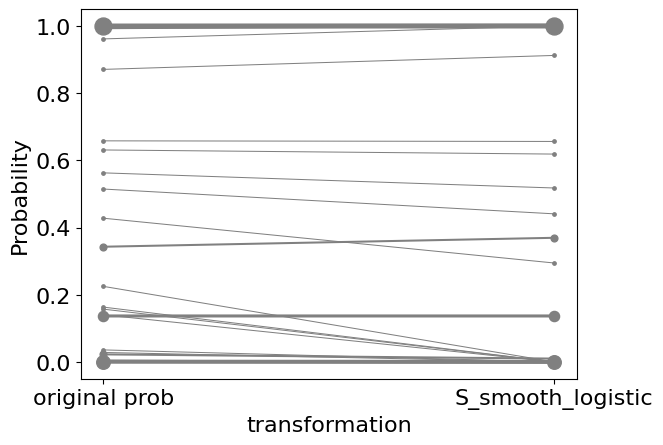

In [68]:
var = "S_smooth_logistic"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

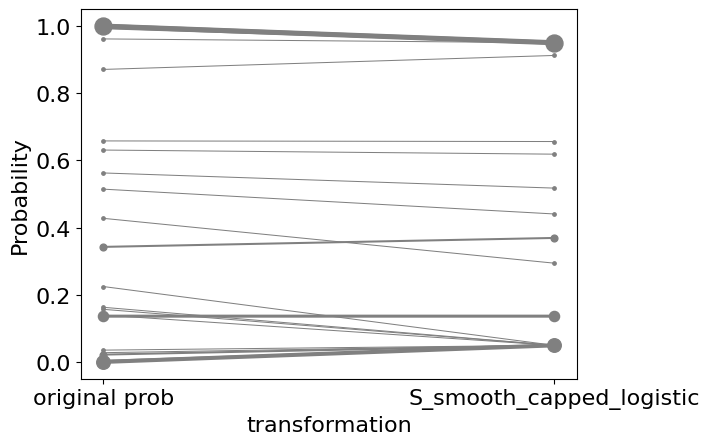

In [69]:
var = "S_smooth_capped_logistic"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

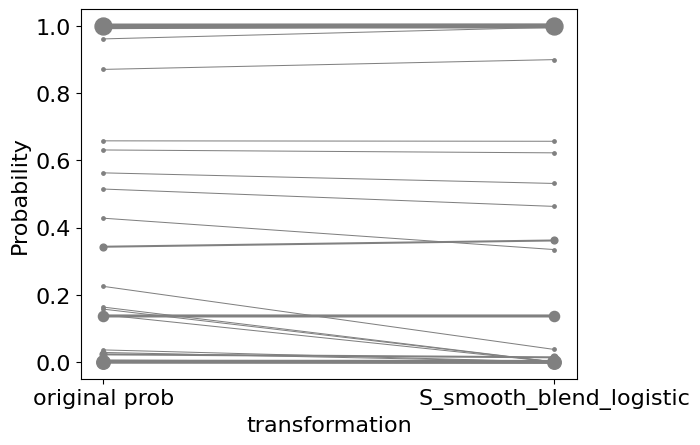

In [70]:
var = "S_smooth_blend_logistic"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

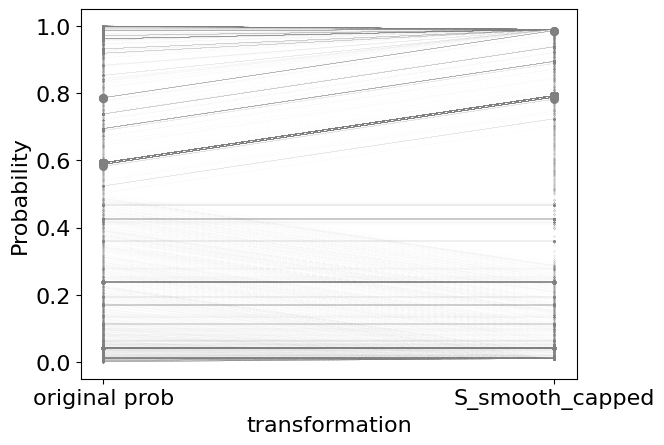

In [71]:
var = "S_smooth_capped"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 1000  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

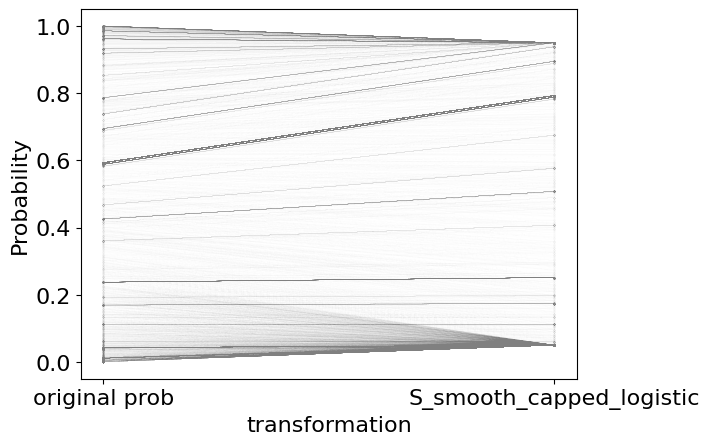

In [72]:
var = "S_smooth_capped_logistic"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

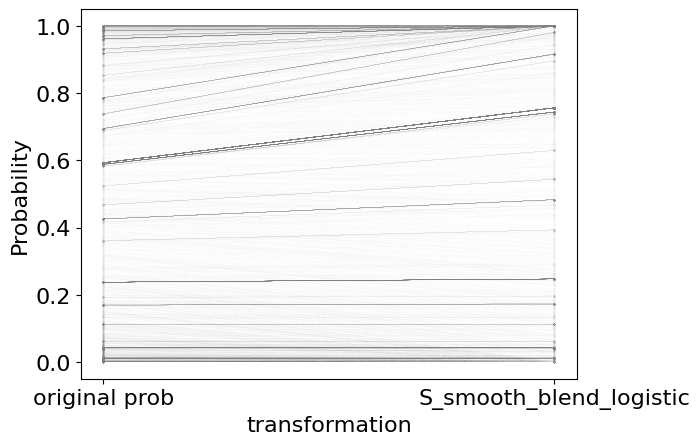

In [73]:
var = "S_smooth_blend_logistic"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

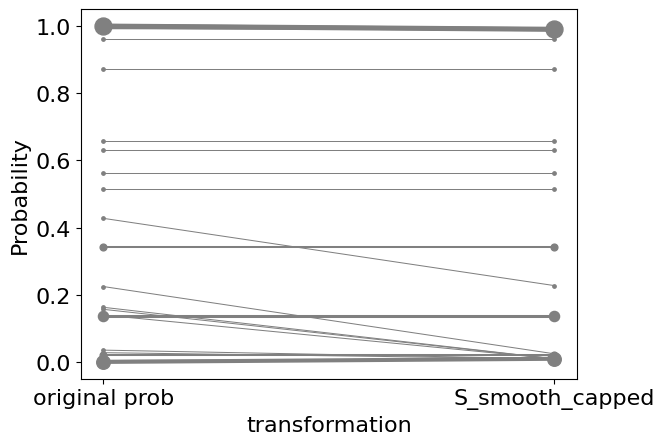

In [74]:
var = "S_smooth_capped"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

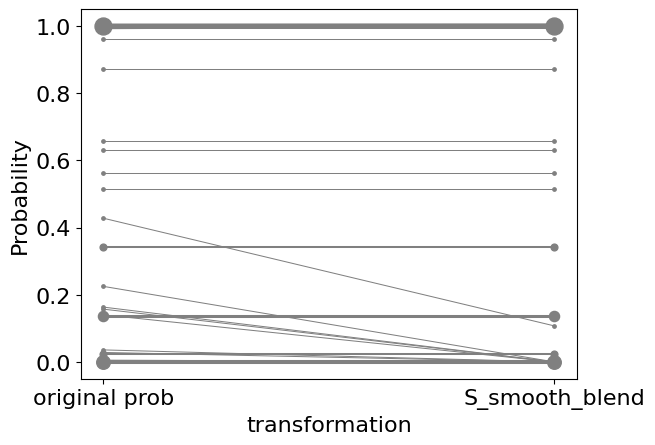

In [75]:
var = "S_smooth_blend"
# Normalize weights for better scaling
sizes = dfs[0]["CloneFreq"] * 100  # dot sizes
widths = dfs[0]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[0])):
    plt.plot(
        [1, 2],
        [dfs[0]["prob"][i], dfs[0][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

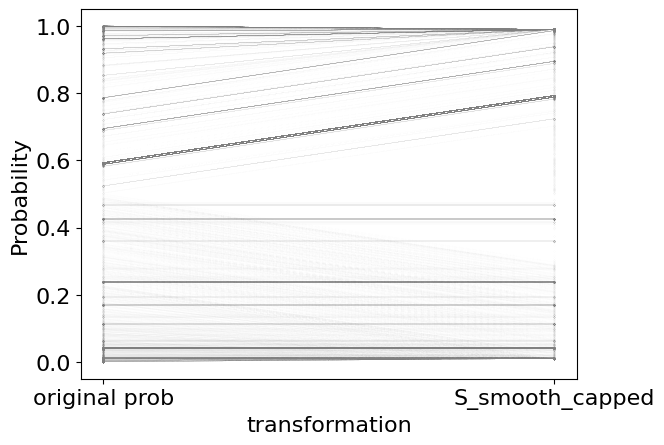

In [76]:
var = "S_smooth_capped"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

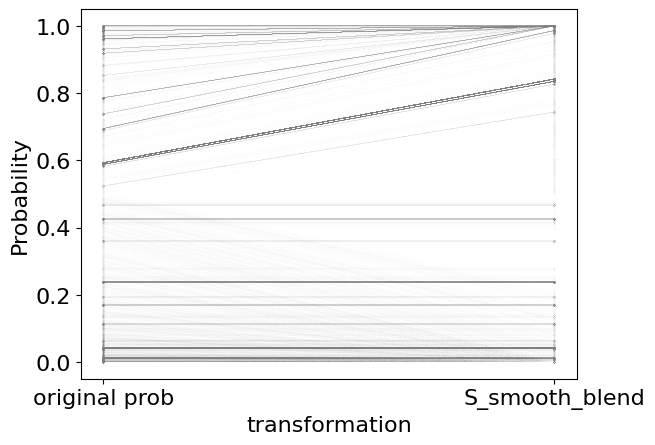

In [77]:
var = "S_smooth_blend"
# Normalize weights for better scaling
sizes = dfs[1]["CloneFreq"] * 100  # dot sizes
widths = dfs[1]["CloneFreq"] * 30  # line widths

for i in range(len(dfs[1])):
    plt.plot(
        [1, 2],
        [dfs[1]["prob"][i], dfs[1][var][i]],
        marker="o",
        color="gray",
        markersize=sizes[i],  # matplotlib uses marker area scaling
        linewidth=widths[i],
    )

plt.xticks([1, 2], ["original prob", var])
plt.xlabel("transformation")
plt.ylabel("Probability")

plt.show()

In [78]:
df_tumor = df[df["sample"] == "cancer"]
df_normal = df[df["sample"] == "control"]
df_tumor

,AA_seq,CloneFreq,prob,high,transformed_score,sample,S_smooth_logistic,R_smooth,S_smooth_capped_logistic,R_smooth_capped,S_smooth_blend_logistic,R_smooth_blend,S_smooth_capped,S_smooth_blend
0,CSVERGYNEQFF,0.121951,0.999494,True,0.121889,cancer,1.000000,1.00,0.950000,1.00,1.000000,1.00,0.990000,1.000000
1,CASSSGTSGGHTDTQYF,0.097561,1.000000,True,0.097561,cancer,1.000000,0.94,0.950000,0.94,1.000000,0.94,0.990000,1.000000
2,CATSGQGAYEQYF,0.097561,0.000680,False,0.000066,cancer,0.000000,0.94,0.050000,0.94,0.000000,0.94,0.010000,0.000680
3,CASSSDRNGYTF,0.073171,0.136786,False,0.010009,cancer,0.136774,0.88,0.136774,0.88,0.136778,0.88,0.136786,0.136786
4,CAWSPGGGLQEQFF,0.048780,0.342822,False,0.016723,cancer,0.369418,0.80,0.369418,0.80,0.361439,0.80,0.342822,0.342822
5,CASRYWLGASTDTQYF,0.048780,0.993213,True,0.048449,cancer,1.000000,0.80,0.950000,0.80,1.000000,0.80,0.990000,1.000000
6,CSVERAVGEAFF,0.048780,0.022431,False,0.001094,cancer,0.009913,0.80,0.050000,0.80,0.013668,0.80,0.022431,0.022431
7,CASSLGGQGTDYGYTF,0.024390,0.999735,True,0.024384,cancer,1.000000,0.36,0.950000,0.36,1.000000,0.36,0.990000,0.999735
8,CASSFGQGTDTF,0.024390,0.870617,True,0.021234,cancer,0.912163,0.36,0.912163,0.36,0.899699,0.36,0.870617,0.870617
9,CSAKQGRSPLHF,0.024390,0.224882,False,0.005485,cancer,0.000000,0.36,0.050000,0.36,0.037132,0.36,0.024882,0.000000


In [ ]:
print(df_normal["prob"].mean())
print(df_normal["S_smooth_capped"].mean())
print(df_normal["S_smooth_capped"].median())

0.47353233997138394
0.44241722593370075
0.2734436720609664
0.43148936331272125


Median: 0.2734436720609664


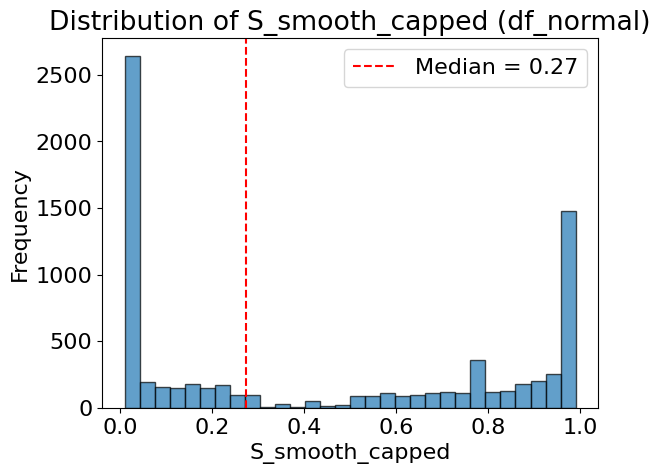

In [82]:
import matplotlib.pyplot as plt

# Compute median
median_val = df_normal["S_smooth_capped"].median()
print("Median:", median_val)

# Plot distribution
plt.hist(df_normal["S_smooth_capped"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(median_val, color="red", linestyle="--", label=f"Median = {median_val:.2f}")
plt.xlabel("S_smooth_capped")
plt.ylabel("Frequency")
plt.title("Distribution of S_smooth_capped (df_normal)")
plt.legend()
plt.show()

Mean: 0.47353233997138394


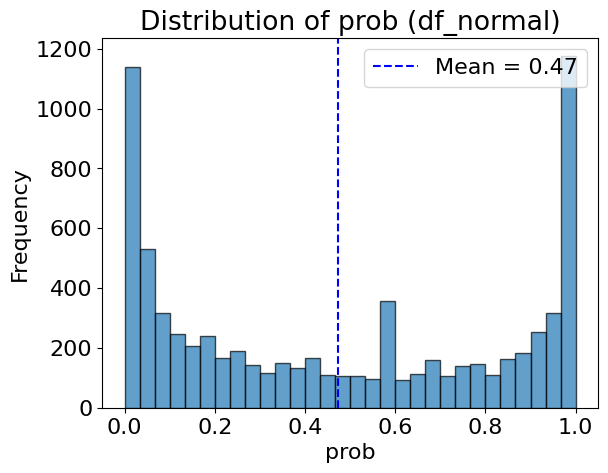

In [83]:
import matplotlib.pyplot as plt

# Compute mean
mean_val = df_normal["prob"].mean()
print("Mean:", mean_val)

# Plot distribution
plt.hist(df_normal["prob"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(mean_val, color="blue", linestyle="--", label=f"Mean = {mean_val:.2f}")
plt.xlabel("prob")
plt.ylabel("Frequency")
plt.title("Distribution of prob (df_normal)")
plt.legend()
plt.show()

In [80]:
print(df_tumor["prob"].mean())
print(df_tumor["S_smooth_capped"].mean())
print(df_tumor["S_smooth_capped"].median())

0.4948736834608448
0.4601026404734988
0.42867644131183624


In [ ]:
import matplotlib.pyplot as plt

# Compute median
median_val = df_tumor["S_smooth_capped"].median()
print("Median:", median_val)

# Plot distribution
plt.hist(df_tumor["S_smooth_capped"], bins=30, edgecolor="black", alpha=0.7)
plt.axvline(median_val, color="red", linestyle="--", label=f"Median = {median_val:.2f}")
plt.xlabel("S_smooth_capped")
plt.ylabel("Frequency")
plt.title("Distribution of S_smooth_capped (df_normal)")
plt.legend()
plt.show()